In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mm_sbi_review.examples.turin import (
    turin,
    compute_turin_summaries,
    compute_turin_summaries_with_max,
)
import torch
import pickle as pkl

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
N = 100

x_data_full = (
    torch.tensor(np.load("../data/turin_obs.npy")).float().reshape(N, 801).to(device)
)
delta_f = 5000000.0

x_obs = compute_turin_summaries_with_max(x_data_full, delta_f=delta_f)
x_obs

tensor([-2.4048e+04, -2.4717e-03, -3.3193e-10, -7.9630e+01, -1.2417e+02,
        -1.2643e+02,  8.9854e+00, -7.0041e+00, -2.2693e+01, -2.2945e+01,
        -3.8616e+01, -5.4270e+01])

In [4]:
# get all relevant posteriors

# SNL
with open("../data/snl_posterior_samples_with_max.npy", "rb") as f:
    snl_max_samples = np.load(f)

# RSNL
with open("../data/turin_rsnl/rsnl_max_theta_posterior_samples.pkl", "rb") as f:
    rsnl_samples = pkl.load(f)
    rsnl_samples = np.concatenate(rsnl_samples, axis=0)

# NPE-MMD
# read npers_posterior.pkl
with open("../data/npe-rs_posterior_samples.npy", "rb") as f:
    npers_samples = np.load(f)

# NPE
with open("../data/npe_posterior_samples_with_max.npy", "rb") as f:
    npe_samples = np.load(f)


# RNPE
with open("../data/rnpe_posterior_samples.pkl", "rb") as f:
    rnpe_samples = pkl.load(f)
    rnpe_samples = rnpe_samples["posterior_samples"]["RNPE"][
        :, 0, :
    ]  # NOTE: strange shape? (1000, 1000, 4)
    rnpe_samples = np.array(rnpe_samples)

In [5]:
# rnpe_samples["posterior_samples"]["RNPE"][:, 0, :]s

(1000, 4)
(40000, 4)
(10000, 4)
(1000, 4)
(1000, 4)


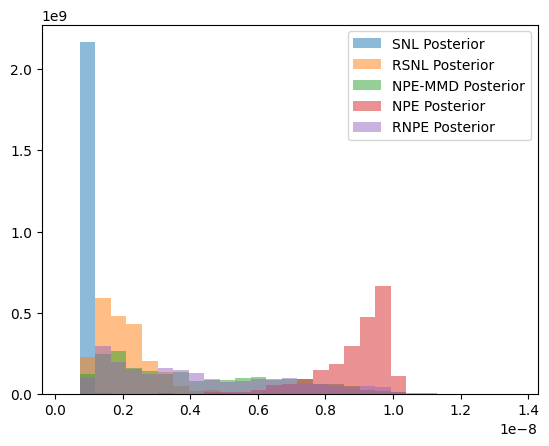

(1000, 4)
(40000, 4)
(10000, 4)
(1000, 4)
(1000, 4)


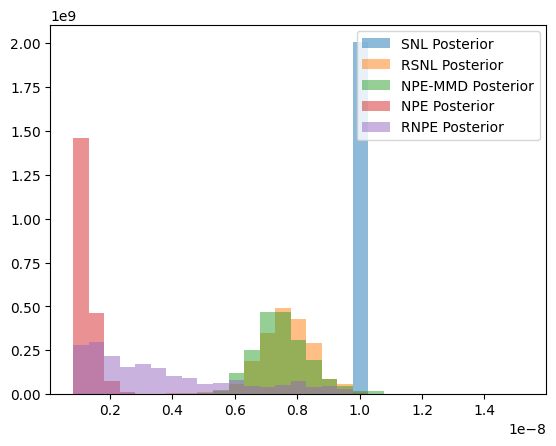

(1000, 4)
(40000, 4)
(10000, 4)
(1000, 4)
(1000, 4)


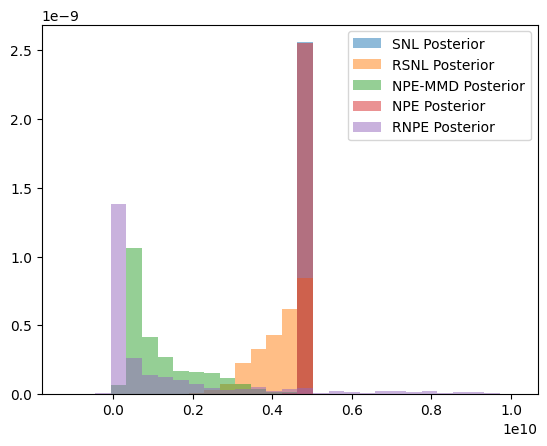

(1000, 4)
(40000, 4)
(10000, 4)
(1000, 4)
(1000, 4)


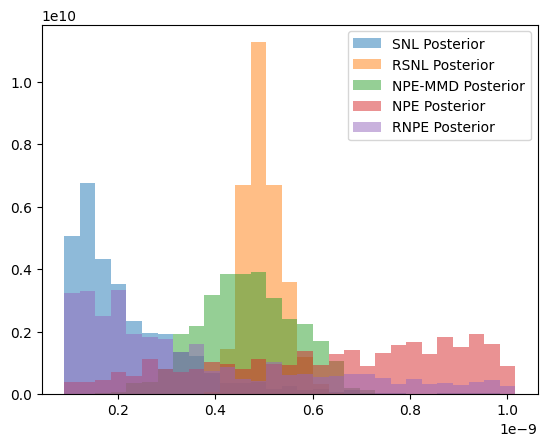

<Figure size 640x480 with 0 Axes>

In [6]:
method_posterior_samples = [
    snl_max_samples,
    rsnl_samples,
    npers_samples,
    npe_samples,
    rnpe_samples,
]
labels = ["SNL", "RSNL", "NPE-MMD", "NPE", "RNPE"]
for i in range(4):
    _, bins = np.histogram(npers_samples[:, i], bins=30, density=True)  # get bin edges
    min_bin = min([np.min(samples[:, i]) for samples in method_posterior_samples])
    max_bin = max([np.max(samples[:, i]) for samples in method_posterior_samples])
    bins = np.linspace(min_bin, max_bin, 30)
    for jj, samples in enumerate(method_posterior_samples):
        print(samples.shape)
        plt.hist(
            samples[:1000, i],
            bins=bins,
            density=True,
            label=f"{labels[jj]} Posterior",
            alpha=0.5,
        )
    plt.legend()
    plt.show()
    plt.clf()

In [7]:
import jax.numpy as jnp
import numpy as np
from functools import partial


# --- 1. helpers --------------------------------------------------------------
def rbf_kernel(x, y, ell):
    return jnp.exp(-jnp.sum((x - y) ** 2, axis=-1) / (2 * ell**2))


def median_heuristic(x, batch=1_000):
    """Median of pairwise ℓ2 distances (memory-friendly)."""
    n = x.shape[0]

    def dists(i):
        sl = slice(i * batch, min((i + 1) * batch, n))
        a = x[sl, None, :]
        return jnp.sqrt(jnp.sum((a - x[None, :, :]) ** 2, -1)).ravel()

    return jnp.sqrt(
        jnp.median(jnp.concatenate([dists(i) for i in range((n + batch - 1) // batch)]))
        / 2.0
    )
    # return 1.0


def unbiased_mmd(sims, x_obs, ell):
    l = sims.shape[0]

    k_xx = rbf_kernel(sims[:, None, :], sims[None, :, :], ell)  # (l,l)
    k_xy = rbf_kernel(sims, x_obs[None, :], ell).reshape(l)  # (l,)
    mmd2 = k_xx.sum() / (l**2) - 2.0 * k_xy.sum() / l + 1.0
    # k_xx.sum() / m**2 - 2 * k_xy.sum() / m
    return mmd2


# convenience wrapper that does the length-scale search once
def mmd_with_median(x, y):
    ell = median_heuristic(jnp.concatenate([x, y], axis=0))
    return unbiased_mmd(x, y, ell)

In [8]:
def temporalMomentsGeneral_turin(Y, K=4, B=4e9):
    N, Ns = Y.shape
    eps = 1e-16
    delta_f = B / (Ns - 1)
    t_max = 1 / delta_f
    tau = np.linspace(0, t_max, Ns)
    out = np.zeros((N, K))
    for k in range(K):
        for i in range(N):
            y = np.fft.ifft(Y[i, :])
            out[i, k] = np.trapz(tau ** (k) * (np.abs(y) ** 2), tau)
    return np.log(out + eps)

In [9]:
[type(samples) for samples in method_posterior_samples]

[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

In [ ]:
# Calculate MMD of posterior predictive and real
B = 4e9
Ns = 801
N = 100
turin_sim = turin(B=B, Ns=Ns, N=N, tau0=0)
x_data_full = jnp.array(x_data_full)
x_temporal_obs = temporalMomentsGeneral_turin(x_data_full, K=4, B=B).mean(0)
num_post_pred_sims = 100  # use a bigger draw for a stable estimate
mmd_scores = []
mmd_scores_tmp = []

x_obs = jnp.array(x_obs)

all_data_raw_all_methods = []
for samples in method_posterior_samples:  # shape (n_theta, 4)
    all_data = []
    all_data_tmp = []
    all_data_raw = []  # TODO: save so can plot PPC
    for i in range(num_post_pred_sims):
        # draw from the posterior
        theta_draws = samples[i, :]
        theta_draws = torch.tensor(theta_draws)
        data = turin_sim(theta_draws)  # (801,)
        summaries_tmp = temporalMomentsGeneral_turin(data, K=4, B=B).mean(0)
        # TODO: also try with other summaries at same time to test
        summaries = compute_turin_summaries_with_max(data, delta_f=delta_f)
        all_data_tmp.append(jnp.array(summaries_tmp).flatten())
        all_data.append(jnp.array(summaries).flatten())
        all_data_raw.append(np.array(data))

    all_data = jnp.stack(jnp.array(all_data))  # (12, 801)
    all_data_tmp = jnp.stack(jnp.array(all_data_tmp))  # (5, 4)
    all_data_raw = np.stack(all_data_raw)
    # MMD²  (paper reported the *square-root*; take sqrt if you want ↑)
    mmd2 = mmd_with_median(all_data, jnp.expand_dims(x_obs.flatten(), axis=0))
    mmd2_tmp = mmd_with_median(
        all_data_tmp, jnp.expand_dims(x_temporal_obs.flatten(), axis=0)
    )
    mmd_scores.append(float(mmd2))
    mmd_scores_tmp.append(float(mmd2_tmp))
    all_data_raw_all_methods.append(all_data_raw)

mmd = [np.sqrt(s) for s in mmd_scores]
mmd_tmp = [np.sqrt(s) for s in mmd_scores_tmp]
snl_max_samples, npers_samples, npe_samples
print(mmd)  # one value per method: [SNL, RSNL, NPE-MMD, NPE, RNPE]
print(mmd_tmp)  # one value per method: [SNL, RSNL, NPE-MMD, NPE, RNPE]

In [ ]:
all_data_raw_all_methods[0].shape

(100, 100, 801)

In [ ]:
all_data_raw_all_methods

[array([[[-104.31752 ,  -91.934555,  -97.17897 , ..., -112.70079 ,
          -109.05031 , -108.30473 ],
         [-102.255516, -102.87523 , -110.31101 , ..., -112.66732 ,
          -109.8546  , -108.40007 ],
         [ -98.612366,  -91.32141 ,  -95.00395 , ..., -104.66614 ,
          -102.48065 , -101.26991 ],
         ...,
         [ -86.7178  ,  -91.82295 ,  -87.68393 , ..., -108.45722 ,
          -105.85282 , -102.13925 ],
         [ -98.82097 ,  -93.73809 , -105.36431 , ..., -111.89891 ,
          -114.408226, -105.733475],
         [ -88.667465,  -94.19544 ,  -84.19216 , ..., -102.0527  ,
           -99.0309  ,  -96.30876 ]],
 
        [[-104.46927 ,  -86.92463 ,  -99.37131 , ..., -120.74861 ,
          -117.541725, -111.16077 ],
         [-103.03318 ,  -99.90261 ,  -94.13886 , ..., -109.474495,
          -106.66048 , -105.23925 ],
         [ -95.22935 ,  -94.4043  ,  -95.7663  , ..., -118.372925,
          -115.02107 , -109.25938 ],
         ...,
         [-109.26555 , -104.38888

## PPCs

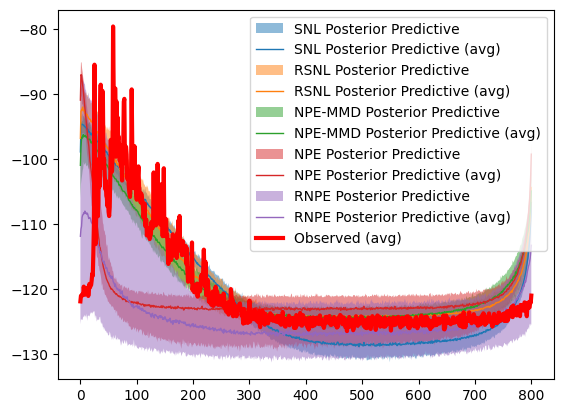

In [ ]:
x_data_avg = np.mean(x_data_full, axis=0)
quantiles = [0.025, 0.5, 0.975]

# Create a figure
plt.figure()
all_data_raw_all_methods
for i, all_data_raw in enumerate(all_data_raw_all_methods):
    avg_list_all = []
    q025_list = []
    q50_list = []
    q975_list = []
    for t in range(all_data_raw.shape[-1]):
        avg_list = []
        for j in range(all_data_raw.shape[0]):
            tmp_avg = np.mean(all_data_raw[j, :, t])
            avg_list.append(tmp_avg)
        q025 = np.quantile(avg_list, 0.025)
        q50 = np.quantile(avg_list, 0.5)
        q975 = np.quantile(avg_list, 0.975)
        q025_list.append(q025)
        q50_list.append(q50)
        q975_list.append(q975)
    plt.fill_between(
        np.arange(all_data_raw.shape[-1]),
        q025_list,
        q975_list,
        alpha=0.5,
        label=f"{labels[i]} Posterior Predictive",
    )
    plt.plot(
        np.arange(all_data_raw.shape[-1]),
        q50_list,
        linewidth=1,
        label=f"{labels[i]} Posterior Predictive (avg)",
    )


# Plot observed average
plt.plot(x_data_avg, color="red", linewidth=3, label="Observed (avg)")
plt.legend()

In [ ]:
x_data_full.shape

(100, 801)

In [ ]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 14,
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.grid": True,
        "grid.alpha": 0.2,
        "grid.linestyle": "--",
    }
)

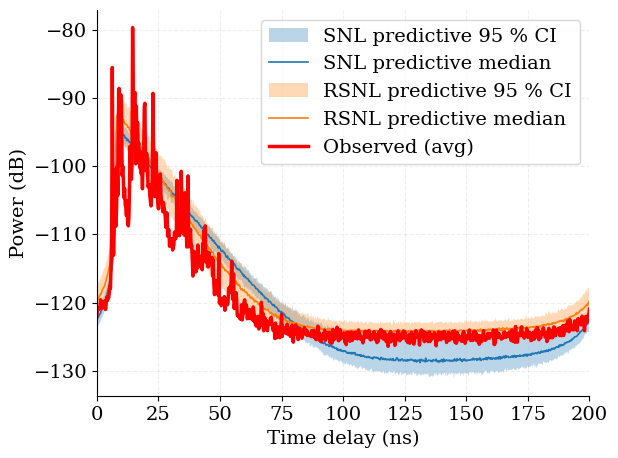

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"SNL", "RSNL"}
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, q50_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        avg_vals = data[:, :, t].mean(axis=1)
        q025_list.append(np.quantile(avg_vals, 0.025))
        q50_list.append(np.quantile(avg_vals, 0.50))
        q975_list.append(np.quantile(avg_vals, 0.975))

    q025_list = np.roll(q025_list, -shift)
    q50_list = np.roll(q50_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4  # time in nanoseconds
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} predictive 95 % CI"
    )
    plt.plot(time, q50_list, linewidth=1.2, label=f"{label} predictive median")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed (avg)")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.tight_layout()
plt.savefig("figs/nle_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.show()

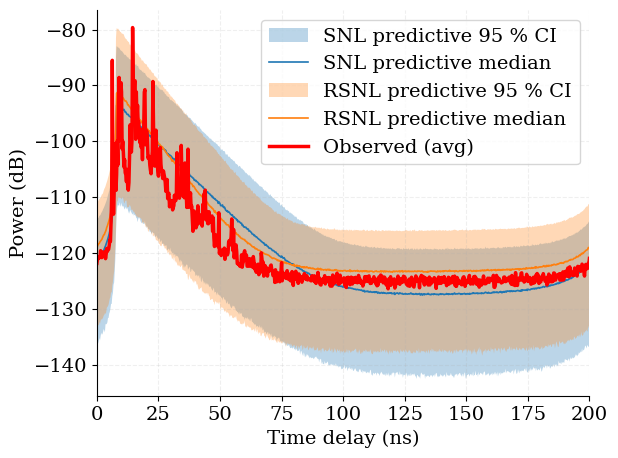

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"SNL", "RSNL"}
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, q50_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        all_vals_t = data[:, :, t].flatten()
        q025_list.append(np.quantile(all_vals_t, 0.025))
        q50_list.append(np.quantile(all_vals_t, 0.50))
        q975_list.append(np.quantile(all_vals_t, 0.975))

    q025_list = np.roll(q025_list, -shift)
    q50_list = np.roll(q50_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4  # time in nanoseconds
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} predictive 95 % CI"
    )
    plt.plot(time, q50_list, linewidth=1.2, label=f"{label} predictive median")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed (avg)")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.tight_layout()
plt.savefig("figs/nle_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.show()

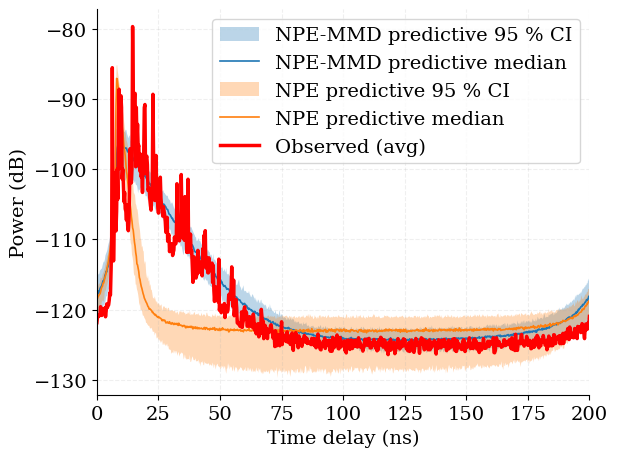

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"NPE", "NPE-MMD"}
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, q50_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        avg_vals = data[:, :, t].mean(axis=1)
        q025_list.append(np.quantile(avg_vals, 0.025))
        q50_list.append(np.quantile(avg_vals, 0.50))
        q975_list.append(np.quantile(avg_vals, 0.975))

    q025_list = np.roll(q025_list, -shift)
    q50_list = np.roll(q50_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} predictive 95 % CI"
    )
    plt.plot(time, q50_list, linewidth=1.2, label=f"{label} predictive median")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed (avg)")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.savefig("figs/npe_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

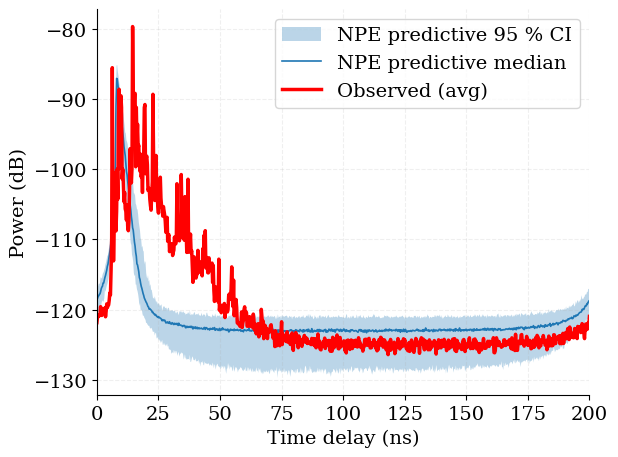

In [ ]:
# just plot NPE
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"NPE"}
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, q50_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        avg_vals = data[:, :, t].mean(axis=1)
        q025_list.append(np.quantile(avg_vals, 0.025))
        q50_list.append(np.quantile(avg_vals, 0.50))
        q975_list.append(np.quantile(avg_vals, 0.975))

    q025_list = np.roll(q025_list, -shift)
    q50_list = np.roll(q50_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} predictive 95 % CI"
    )
    plt.plot(time, q50_list, linewidth=1.2, label=f"{label} predictive median")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed (avg)")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.savefig("figs/npe_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

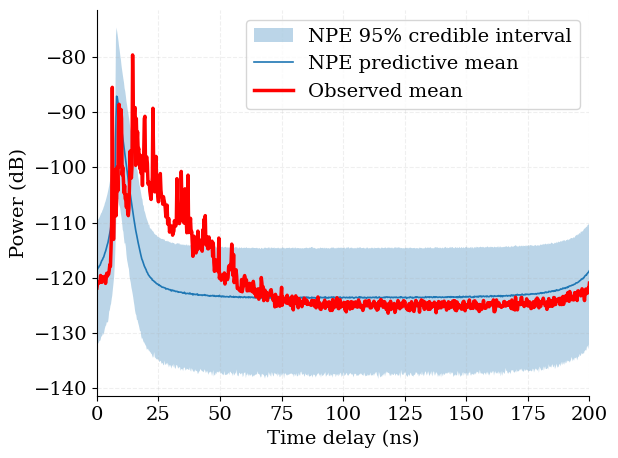

In [ ]:
# just plot NPE
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"NPE"}
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, mean_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        q025_list.append(np.quantile(data[:, :, t], 0.025))
        mean_list.append(np.mean(data[:, :, t]))
        q975_list.append(np.quantile(data[:, :, t], 0.975))

    q025_list = np.roll(q025_list, -shift)
    mean_list = np.roll(mean_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} 95% credible interval"
    )
    plt.plot(time, mean_list, linewidth=1.2, label=f"{label} predictive mean")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed mean")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.savefig("figs/npe_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

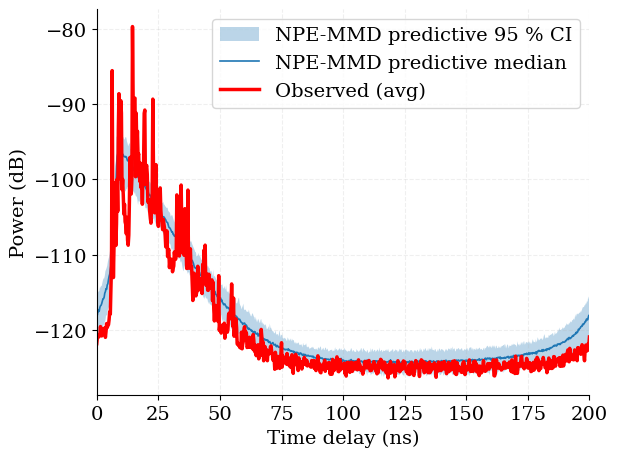

In [ ]:
# just plot NPE
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"NPE-MMD"}  # TODO: SMC-ABC MMD?
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, q50_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        avg_vals = data[:, :, t].mean(axis=1)
        q025_list.append(np.quantile(avg_vals, 0.025))
        q50_list.append(np.quantile(avg_vals, 0.50))
        q975_list.append(np.quantile(avg_vals, 0.975))

    q025_list = np.roll(q025_list, -shift)
    q50_list = np.roll(q50_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} predictive 95 % CI"
    )
    plt.plot(time, q50_list, linewidth=1.2, label=f"{label} predictive median")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed (avg)")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.savefig("figs/npe_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

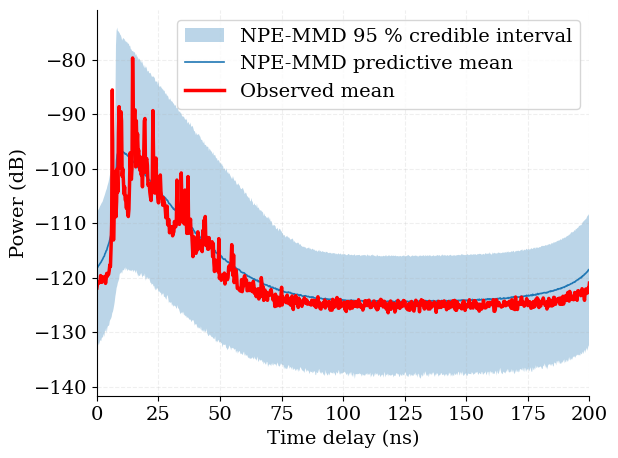

In [ ]:
# just plot NPE
import numpy as np
import matplotlib.pyplot as plt

# Average of the observed data
x_data_avg = np.mean(x_data_full, axis=0)

# Methods we want to keep
keep = {"NPE-MMD"}
# keep = {"RSNL",}

plt.figure()

shift = 770

for label, data in zip(labels, all_data_raw_all_methods):
    if label not in keep:
        continue  # skip anything that isn’t SNL, RSNL, or RNPE

    q025_list, mean_list, q975_list = [], [], []
    for t in range(data.shape[-1]):
        # mean over simulations for each replicate
        q025_list.append(np.quantile(data[:, :, t], 0.025))
        mean_list.append(np.mean(data[:, :, t]))
        q975_list.append(np.quantile(data[:, :, t], 0.975))

    q025_list = np.roll(q025_list, -shift)
    mean_list = np.roll(mean_list, -shift)
    q975_list = np.roll(q975_list, -shift)

    time = np.arange(data.shape[-1]) / 4
    plt.fill_between(
        time, q025_list, q975_list, alpha=0.3, label=f"{label} 95 % credible interval"
    )
    plt.plot(time, mean_list, linewidth=1.2, label=f"{label} predictive mean")

# Observed data
plt.plot(time, x_data_avg, color="red", linewidth=2.5, label="Observed mean")

plt.legend()
plt.xlim(0, 200)
plt.xlabel("Time delay (ns)")
plt.ylabel("Power (dB)")
plt.savefig("figs/npers_turin_posterior_predictive.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 11,
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)


def _bands(data: np.ndarray, shift: int = 770):
    # data: (num_sims, N_reps, T)
    T = data.shape[-1]
    flat = data.reshape(-1, T)  # pool sims × reps
    q025 = np.quantile(flat, 0.025, axis=0)
    mean = flat.mean(axis=0)
    q975 = np.quantile(flat, 0.975, axis=0)
    return np.roll(q025, -shift), np.roll(mean, -shift), np.roll(q975, -shift)


idx_npe = labels.index("NPE")
idx_npemmd = labels.index("NPE-MMD")

T = all_data_raw_all_methods[0].shape[-1]
time = np.arange(T) / 4.0  # ns
obs = x_data_full
obs = obs.detach().cpu().numpy() if hasattr(obs, "detach") else np.asarray(obs)
obs_mean = obs.mean(axis=0)  # do not roll observed

fig, axes = plt.subplots(
    1, 2, sharex=True, sharey=True, figsize=(6.9, 2.6)
)  # ~1‑col width
for ax, idx, tag in zip(axes, [idx_npe, idx_npemmd], ["(a) NPE", "(b) NPE‑MMD"]):
    q025, mean, q975 = _bands(all_data_raw_all_methods[idx])
    ax.fill_between(time, q025, q975, alpha=0.30, label="95% credible interval")
    ax.plot(time, mean, linewidth=1.2, label="predictive mean")
    ax.plot(time, obs_mean, color="red", linewidth=2.0, label="observed mean")
    ax.set_title(tag, pad=2, fontsize=12)
    ax.set_xlim(0, 200)
    ax.set_xlabel("Time delay (ns)")
axes[0].set_ylabel("Power (dB)")

handles, labs = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labs, ncol=3, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.05)
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig("figs/turin_ppc_npe_vs_npemmd.pdf", bbox_inches="tight")
plt.close(fig)

In [ ]:
num_post_pred_sims = 100
B = 4e9
Ns = 801
N = 100
turin_sim = turin(B=B, Ns=801, N=N, tau0=0)

x_data_avg = torch.mean(x_data_full, dim=0)

# Create a figure
plt.figure()

# Plot observed average
plt.plot(x_data_avg.cpu().numpy(), color="red", linewidth=3, label="Observed (avg)")


for i in range(num_post_pred_sims):
    # theta = torch.tensor(samples[i, :])
    # data = turin_sim(theta)
    x_posterior_pred_avg = torch.mean(data, dim=0)

    # Only add a legend label to the first prior draw, to avoid clutter
    if i == 0:
        plt.plot(
            x_posterior_pred_avg.cpu().numpy(),
            linewidth=1,
            alpha=0.2,
            label="Posterior draws",
        )
    else:
        plt.plot(x_posterior_pred_avg.cpu().numpy(), alpha=0.2)

# A few labels and legend
plt.xlabel("Time index")
plt.ylabel("Power (dB)")
plt.title("Posterior Predictive Checks")
plt.legend()

# Save the figure
plt.savefig("figs/turin_posterior_predictive_checks_full_data.pdf")

TypeError: mean() received an invalid combination of arguments - got (ArrayImpl, dim=int), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
